In [1]:
import zipfile
import requests
from pathlib import Path
import os

import numpy as np
# Scikit check

import matplotlib.pyplot as plt

from torchvision.utils import save_image  # for saving torchform images
from torchvision import transforms , datasets       # for torch tensor transforms
import torchvision
import random

#For reading image
import PIL
from PIL import Image

import torch

#TO get progress bar:
from tqdm.auto import tqdm

from scipy.stats import ks_2samp # stat
from scipy import stats

# for downloading zipped data:
import shutil
from google.colab import files

import time # To measure time of code execution

In [2]:
def get_data(source : str ,
                  destination : str , ) -> Path :
  '''Get a zipdataset from source and unzips to destination.
  Returns data path.
  '''
  # Setup path to data folder
  data_path = Path('')
  image_path = data_path / destination

  #Make directory
  image_path.mkdir(parents = True , exist_ok = True )

  # Unzip target file :
  with zipfile.ZipFile(source , 'r' ) as zip_ref :
    print(f'Unzipping {source} data...')
    zip_ref.extractall(image_path)

  return image_path

In [3]:
# # print(os.listdir())

In [4]:
zip_file_path = '/content/drive/MyDrive/DaneMikroskopPraktyka.zip'
zip_file_path

'/content/drive/MyDrive/DaneMikroskopPraktyka.zip'

In [5]:
#New direcotry for unzipped data
data_destination = 'data_all'

get_data(source = zip_file_path ,
              destination = data_destination )

Unzipping /content/drive/MyDrive/DaneMikroskopPraktyka.zip data...


PosixPath('data_all')

In [6]:
def load_image(img_path , check : bool = False):
  '''Load image from `img_path`.
  Args:
    img_path(str): path of particular image.
    check(bool , optional): Be default check=False, for check=True print size of image.
  '''

  image = Image.open(img_path).convert('RGB')

  if check :
    print(f'Size of Image: {image.size}', '\n')

  #Get torch tensor for comparisons
  transform = transforms.Compose( [transforms.ToTensor() ])

  # Transform the image and move back to [H , W , CC]
  image = transform(image)[:,:,:]
  image = image.permute(1,2,0)

  return image

In [7]:
def crop_image(img_path , crop_size : int = 300  , check : bool = False):
  '''Load, crop and check statistical signifficance of image from `img_path`.
  Args:
    img_path (str): path of original image.
    crop_size (int, optional): size of cropped image (crop_size, crop_size). By default set to 300.
    check(bool , optional): Be default check=False, for check=True print size of image before and after cropping.
  Returns: return cropped image in form of torch tensor [H , W , CC].
  '''

  image = Image.open(img_path).convert('RGB')
  max_width , max_height = image.size   # PIL has values in format: [W , H , CC]


  if check :
    print(f'Size before cropping: {image.size}')


  # Check if the image is smaller than the crop size
  if max_height <= crop_size or max_width <= crop_size:
    raise ValueError("Image dimensions are smaller than the crop size!")

  # Transform to tensor:
  transform = transforms.Compose([transforms.ToTensor(), ])  # from PIL format [W,H,CC] into torch --> [CC,H,W,]

  # Transform the image and move to form for plotting:[H , W , CC]
  image = transform(image)[:,:,:]
  image = image.permute(1,2,0)


  start_point_h = random.randint(0 , (max_height - crop_size) )
  start_point_w = random.randint(0 , (max_width - crop_size) )

  image = image[start_point_h : start_point_h +crop_size , start_point_w : start_point_w + crop_size , : ]

  if check :
    print(f'Values after cropping: shape: {image.shape} , Datatype: {image.dtype} ')


  return image

In [8]:
def walk_through_dir(dir_path) :
  '''
  Walks through dir_path returning its contents.
  '''
  for dirpath , dirnames , filenames in os.walk(dir_path) :
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

## Checking does everything work correctly:

In [9]:
example_image_path = '/content/data_all/DaneMikroskopPraktyka/SmC/MP 10-18 (10OABOOC17)/c 100.png'

Size of Image: (2560, 1920) 



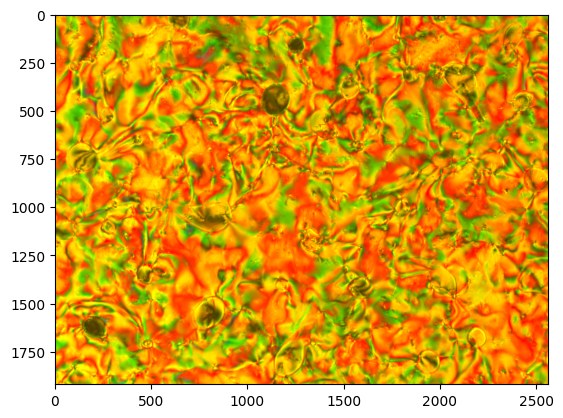

In [10]:
# 1 loaded image just for test to check does everything is working:
org_image = load_image(example_image_path , check = True)
plt.imshow(org_image) ;

Size before cropping: (2560, 1920)
Values after cropping: shape: torch.Size([300, 300, 3]) , Datatype: torch.float32 


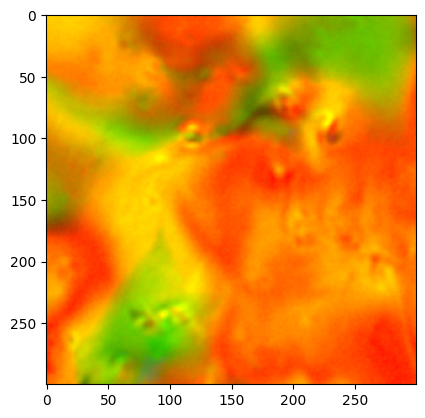

In [11]:
cropped_image1 = crop_image(example_image_path , check = True , crop_size = 300)   # check = True

plt.imshow(cropped_image1) ;

In [12]:
save_image(cropped_image1.permute(2,0,1), 'Test1.png')  # move back to torch format [CC,H,W,] for saving


In [65]:
# Directory containing images

folder_path = '/content/data_all/DaneMikroskopPraktyka'

# List all files in the directory
file_list = os.listdir(folder_path)


file_list = file_list[:1]
file_list

['Nematyk']

In [66]:
#Measure time:
start_time = time.time()


# Loop through each file
for file_name in tqdm(file_list):
  print(file_name)
  inner_file = os.listdir(f'{folder_path}/{file_name}')
  print(inner_file)
  # break

  directory = f'/content/crop_data_tiny_nem/{file_name}'
  if not Path(directory).exists():
    Path(directory).mkdir(parents=True, exist_ok=True)
    print(f'Creating directory: {directory} for class: {file_name}')

  for files in tqdm(inner_file) :
    # print('here')
    current_file = f'{folder_path}/{file_name}/{files}'
    print(f'{current_file}')                                          # MP_cos cos
    current_file_dir = os.listdir(current_file)
    print(current_file_dir)
    for image in current_file_dir :                                   # W danyhm MP COS COS SA dwa obrazki i dla obrazka z tych dwoch
      # print(f'Processing image: {image}')
      image_path = os.path.join(current_file , image )
      # print('------' , image_path , '----------')

      # Check if the file is an some kind of image
      if image.endswith(('.jpg', '.jpeg', '.png', '.tif' ) ):
        # print("Processing image:", image_path)


        ### Cropping and saving images:

        # For every one image cropping 600 images:
        for i in range(30) :
          #Cropping particulary image using function crop_image:
          cropped_image = crop_image(image_path , check = False , crop_size = 300)

          # save_image(cropped_image.permute(2,0,1), f'/content/crop_data/{file_name}/{files}_Cropped_{i}.png')

          # print(f'Saving into: {directory}/{files}_Cropped_{i}.png\n')
          save_image(cropped_image.permute(2,0,1), f'{directory}/{files}_{os.path.splitext(image)[0]}_Cropped_{i}.png')



end_time = time.time()
execution_time = end_time - start_time
print(f'Code execution time: {execution_time}')

  0%|          | 0/1 [00:00<?, ?it/s]

Nematyk
['MP 10-3 (10OABOOC2)', 'MP 10-2 (10OABOOC1)', 'MP 10-9 (10OABOOC8)', 'MP 5-8 (5OABOOC7)', 'HT', 'MP 7-9 (7OABOOC8)', 'MP 7-2 (7OABOOC1)', 'MP 7-12 (7OABOOC11)', 'MP 7-8 (7OABOOC7)', 'MP 7-10 (7OABOOC9)', 'MP 7-3 (7OABOOC2)', 'MP 7-11 (7OABOOC10)', 'MP 8-9 (8OABOOC8)']
Creating directory: /content/crop_data_tiny_nem/Nematyk for class: Nematyk


  0%|          | 0/13 [00:00<?, ?it/s]

/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 10-3 (10OABOOC2)
['+N 100 c.png']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 10-2 (10OABOOC1)
['+N 85 c.png']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 10-9 (10OABOOC8)
['+N 103 c.png']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 5-8 (5OABOOC7)
['t_0076.tif', 't_0077.tif', 't_0075.tif', 'N 100 c.tif']
/content/data_all/DaneMikroskopPraktyka/Nematyk/HT
['102.png', '101.png', '90.png', '70.png', '103.png', '85.png', '98.png', '95 (2).png', '98 (2).png', '95.png']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 7-9 (7OABOOC8)
['t_0010.png', 't_0008.png', 't_0005.png', '7-9 N2.jpg', 't_0009.png', 't_0007.png', 't_0011.png', 't_0006.png', 'Thumbs.db']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 7-2 (7OABOOC1)
['7-2 N1.jpg', '+N c 103.png', 'c 102.png', 'c 100.png', 'c 95.png', 'c 90.png', '7-2 N2.jpg']
/content/data_all/DaneMikroskopPraktyka/Nematyk/MP 7-12 (7OABOOC11)
['c 97.png', 'h 100.png']
/content/dat

In [67]:
walk_through_dir('/content/crop_data_tiny_nem')

There are 1 directories and 0 images in /content/crop_data_tiny_nem
There are 0 directories and 1680 images in /content/crop_data_tiny_nem/Nematyk


In [68]:


#Parent directory to be zipped
parent_directory_to_zip = '/content/crop_data_tiny_nem'

#Name for the zip file
zip_filename = 'crop_data_tiny_nem'


# Zip the directory
shutil.make_archive('/content/' + zip_filename, 'zip', parent_directory_to_zip)


'/content/crop_data_tiny_nem.zip'

In [ ]:
# Download the zip file
# from google.colab import files

# files.download('/content/crop_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>